In [2]:
def GetBottcherComplexity(themol,debug=False):
    complexity = 0
    Chem.AssignStereochemistry(themol,cleanIt=True,force=True,flagPossibleStereoCenters=True)
    atoms = themol.GetAtoms();
    atom_stereo_classes = []
    atoms_corrected_for_symmetry = []
    for atom in atoms:
        if atom.GetProp('_CIPRank') in atom_stereo_classes:
            continue
        else:
            atoms_corrected_for_symmetry.append(atom)
            atom_stereo_classes.append(atom.GetProp('_CIPRank'))
    for atom in atoms_corrected_for_symmetry:
        d = GetChemicalNonequivs(atom, themol)
        e = GetBottcherLocalDiversity(atom)
        s = GetNumIsomericPossibilities(atom)
        V = GetNumValenceElectrons(atom)
        b = GetBottcherBondIndex(atom)
        complexity += d*e*s*math.log(V*b,2)
        if debug:
            PrintDebugInfo(str(atom.GetSymbol()), str(atom.GetProp('_CIPRank')), d, e, s, V, b)
    if debug:
        print('Current Complexity Score: ' + str(complexity))
        return
    return complexity

In [3]:
print("Hello, World!!!!")

Hello, World!!!!


In [4]:
from __future__ import print_function
import csv
import importlib.util
import math
import os
import sys
import seaborn
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir,'ChiralPairs'))
import ChiralDescriptors

In [5]:
# D
#
# Thursday, 12 September 2019: Implemented atom-label-list based comparison.
# Current failures: Does not distinguish between cyclopentyl and pentyl (etc.)
#                   and so unfairly underestimates complexity. 
#
# TODO: Implement logic to determine e.g. whether repeats of CCCCC are cyclopentyl and pentyl or two of either
def GetChemicalNonequivs(atom, themol):
    num_unique_substituents = 0
    substituents = [[],[],[],[]]
    for item,key in enumerate(ChiralDescriptors.determineAtomSubstituents(atom.GetIdx(), themol, Chem.GetDistanceMatrix(themol))[0]):
        for subatom in ChiralDescriptors.determineAtomSubstituents(atom.GetIdx(), themol, Chem.GetDistanceMatrix(themol))[0][key]:
            substituents[item].append(themol.GetAtomWithIdx(subatom).GetSymbol())
    ###
    # Logic to determine e.g. whether repeats of CCCCC are cyclopentyl and pentyl or two of either
    #
    #
    num_unique_substituents = len(set(tuple(tuple(substituent) for substituent in substituents if substituent)))
    return num_unique_substituents

In [6]:
def CompareAtoms(atom1, atom2):
    if(atom1 == atom2):
        return True
    return False

def CompareListsOfAtoms(list1, list2):
    if (len(list1) != len(list2)):
        return False
    return True

def GetChemicalNonequivsNew(atom, themol):
    num_unique_substituents = 0
    # 8 should do; I don't know of an atom with more bonds than Rhenium in [Re_{2}Cl_{8}]^{2-}
    substituents = [[],[],[],[],[],[],[],[]]
    substituents_just_atom_labels = [[],[],[],[],[],[],[],[]]
    for item,key in enumerate(ChiralDescriptors.determineAtomSubstituents(atom.GetIdx(), themol, Chem.GetDistanceMatrix(themol))[0]):
        for subatom in ChiralDescriptors.determineAtomSubstituents(atom.GetIdx(), themol, Chem.GetDistanceMatrix(themol))[0][key]:
            substituents[item].append(themol.GetAtomWithIdx(subatom))
            substituents_just_atom_labels[item].append(themol.GetAtomWithIdx(subatom).GetSymbol())
    # At this point in the program we have the four-membered list of substituents.
    # If the chains are of different lengths then it is impossible for them to be chemically equivalent.
    # Therefore, our first hack will be to check the number of unique substituents and their lengths against each other.
    # But let's rearrange the list so that we have only the substituents that actually exist -- the rest are hydrogen. 
    num_unique_substituents = len(set(tuple(tuple(substituent) for substituent in substituents_just_atom_labels if substituent)))
    return num_unique_substituents


In [7]:
# E
#
# The number of different non-hydrogen elements or isotopes (including deuterium
# and tritium) in the atom's microenvironment.
#
# CH4 - the carbon has e_i of 1
# Carbonyl carbon of an amide e.g. CC(=O)N e_i = 3
#     while N and O have e_i = 2
#
def GetBottcherLocalDiversity(atom):
    neighbors = []
    for neighbor in atom.GetNeighbors():
        neighbors.append(str(neighbor.GetSymbol()))
    if atom.GetSymbol() in set(neighbors):
        return len(set(neighbors))
    else:
        return len(set(neighbors))+1

In [8]:
# S
#
# 
def GetNumIsomericPossibilities(atom):
    try:
        if(atom.GetProp('_CIPCode')):
            return 2
    except:
        return 1

In [9]:
# V
#
# The number of valence electrons the atom would have if it were unbonded and 
# neutral 
#
def GetNumValenceElectrons(atom):
    valence = {1: ['H', 'Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'], # Alkali Metals
               2: ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'], # Alkali Earth Metals
               #transition metals???
               3: ['B', 'Al', 'Ga', 'In', 'Tl', 'Nh'], #
               4: ['C', 'Si', 'Ge', 'Sn', 'Pb', 'Fl'], 
               5: ['N', 'P', 'As', 'Sb', 'Bi', 'Mc'], # Pnictogens
               6: ['O', 'S', 'Se', 'Te', 'Po', 'Lv'], # Chalcogens
               7: ['F', 'Cl', 'Br', 'I', 'At', 'Ts'], # Halogens
               8: ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn', 'Og']} # Noble Gases
    for k in valence:
        if atom.GetSymbol() in valence[k]:
            return k
    return 0

In [10]:
valence = {'alkali': ['H', 'Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'], # Alkali Metals
           'alkali_e': ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'], # Alkali Earth Metals
           #transition metals???
           3: ['B', 'Al', 'Ga', 'In', 'Tl', 'Nh'], #
           4: ['C', 'Si', 'Ge', 'Sn', 'Pb', 'Fl'], 
           5: ['N', 'P', 'As', 'Sb', 'Bi', 'Mc'], # Pnictogens
           6: ['O', 'S', 'Se', 'Te', 'Po', 'Lv'], # Chalcogens
           7: ['F', 'Cl', 'Br', 'I', 'At', 'Ts'], # Halogens
           8: ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn', 'Og']} # Noble Gases


In [11]:
valence['alkali_e'][3]

'Sr'

In [12]:
# B
#
# Represents the total number of bonds to other atoms with V_i*b_i > 1, so
# basically bonds to atoms other than Hydrogen
#
# Here we can leverage the fact that RDKit does not even report Hydrogens by
# default to simply loop over the bonds. We will have to account for molecules
# that have hydrogens turned on before we can submit this code as a patch
# though. 
def GetBottcherBondIndex(atom):
    b_sub_i_ranking = 0
    bonds = []
    for bond in atom.GetBonds():
        bonds.append(str(bond.GetBondType()))
    for bond in bonds:
        if bond == 'SINGLE':
            b_sub_i_ranking += 1
        if bond == 'DOUBLE':
            b_sub_i_ranking += 2
        if bond == 'TRIPLE':
            b_sub_i_ranking += 3
    if 'AROMATIC' in bonds:
        # This list can be expanded as errors arise.
        if atom.GetSymbol() == 'C':
            b_sub_i_ranking += 3
        elif atom.GetSymbol() == 'N':
            b_sub_i_ranking += 2
    return b_sub_i_ranking

In [13]:
def PrintDebugInfo(symbol, symmetry, d_i, e_i, s_i, V_i, b_i):
    print(symbol)
    print('\tSymmetry Class: ' + symmetry)
    #print('\tNeighbors: ')
    #print('\tBonds: ')
    print('\tCurrent Parameter Values:')
    print('\t\td_sub_i: ' + str(d_i))
    print('\t\te_sub_i: ' + str(e_i))
    print('\t\ts_sub_i: ' + str(s_i))
    print('\t\tV_sub_i: ' + str(V_i))
    print('\t\tb_sub_i: ' + str(b_i))



In [14]:
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

def GetTheAtoms(themol, symmetries, halflings=False):
    ###
    # How many times is each _CIPRank represented in each molecule?
    #
    # Cyclohexane/Benzene: 0 is represented 6 times
    #                      0 should be triple counted
    # Cyclopropane: 0 is represented 5 times
    #               0 should be double counted
    #               Then one more divided by 1/2
    #
    # and so on and so on
    #
    # We calculate the number of CIPCodes for each molecule in the main function
    # and then pass it in to this one.
    #
    ###
    # Then, we need to see what the count is for each CIPCode and adjust
    #
    # Say our count of _CIPCode 0 is six, then we need to append that atom
    # to compute_full_complexity three times.
    #
    # If it is five, we need to append to compute_full_complexity twice and
    # compute_half_complexity once.
    #
    # In both cases, we need to remove their CIPCode frem the list of CIPcodes
    # so that no other atom with that CIPCode gets counted.
    #
    # We leverage the fact that each atom with the same CIPCode is by def. the
    # same to accomplish this.
    #
    compute_full_complexity = []
    compute_half_complexity = []
    for atom in themol.GetAtoms():
        number_of_occurrences = symmetries.count(atom.GetProp('_CIPRank'))
        if number_of_occurrences == 1 : 
            compute_full_complexity.append(atom)
            continue;
        else:
            number_of_times_full = number_of_occurrences // 2;
            number_of_times_half = number_of_occurrences % 2;
            for i in range(0,number_of_times_full):
                compute_full_complexity.append(atom)
            for i in range(0,number_of_times_half):
                compute_half_complexity.append(atom)
            symmetries = remove_values_from_list(symmetries, atom.GetProp('_CIPRank'))
            continue;

    if halflings:
        return compute_half_complexity
    else:
        return compute_full_complexity

In [15]:
def GetBottcherComplexityFixSymmetry(themol,debug=False):
    complexity = 0
    ## Assign CIPCodes to each atom in the molecule
    Chem.AssignStereochemistry(themol,cleanIt=True,force=True,flagPossibleStereoCenters=True)
    ## Append each atom's CIPCode to a list
    CIPCodes = []
    for atom in themol.GetAtoms():
        CIPCodes.append(atom.GetProp('_CIPRank'))
    atoms = GetTheAtoms(themol, CIPCodes)
    half_atoms = GetTheAtoms(themol, CIPCodes, True)
    if debug:
        print("FULL ATOMS")
    for atom in atoms:
        d = GetChemicalNonequivsNew(atom, themol)
        e = GetBottcherLocalDiversity(atom)
        s = GetNumIsomericPossibilities(atom)
        V = GetNumValenceElectrons(atom)
        b = GetBottcherBondIndex(atom)
        complexity += d*e*s*math.log(V*b,2)
        if debug:
            PrintDebugInfo(str(atom.GetSymbol()), str(atom.GetProp('_CIPRank')), d, e, s, V, b)
    if half_atoms:
        if debug:
            print("HALF ATOMS")
        for atom in half_atoms:
            d = GetChemicalNonequivsNew(atom, themol)
            e = GetBottcherLocalDiversity(atom)
            s = GetNumIsomericPossibilities(atom)
            V = GetNumValenceElectrons(atom)
            b = GetBottcherBondIndex(atom)
            complexity += (d*e*s*math.log(V*b,2)/2)
            if debug:
                PrintDebugInfo(str(atom.GetSymbol()), str(atom.GetProp('_CIPRank')), d, e, s, V, b)
    if debug:
        print('Current Complexity Score: ' + str(complexity))
        return
    return complexity

In [23]:
xylene = Chem.MolFromSmiles('CC1=CC=C(C=C1)C')
for index, atom in enumerate(xylene.GetAtoms()):
    print(index)
    for bond in atom.GetBonds():
        print(bond.GetBondType())


0
SINGLE
1
SINGLE
AROMATIC
AROMATIC
2
AROMATIC
AROMATIC
3
AROMATIC
AROMATIC
4
AROMATIC
AROMATIC
SINGLE
5
AROMATIC
AROMATIC
6
AROMATIC
AROMATIC
7
SINGLE


In [16]:
GetBottcherComplexityFixSymmetry(Chem.MolFromSmiles('CCC'),True)

FULL ATOMS
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 1
C
	Symmetry Class: 1
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
Current Complexity Score: 5.0


In [17]:
GetBottcherComplexityFixSymmetry(Chem.MolFromSmiles('C1CCCC1'),True)

FULL ATOMS
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
HALF ATOMS
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
Current Complexity Score: 7.5


In [18]:
def Test(molecule):
    currval = GetBottcherComplexityFixSymmetry(molecule[0])
    if(round(currval,2) == molecule[2]):
        print("\t" + molecule[1] + ": \033[1;32;40m PASSED \033[0m", end="\n")
        return 1
    else:
        print("\t" + molecule[1] + ": \033[1;31;40m FAILED \033[0m", end="\n")
        print("\t\tCurrent: " + str(round(currval,2)) + " Reference: " + str(molecule[2]))
        return 0

def RunTests():
    score = 0
    tested = 0
    molecules = []

    # Worksheet Molecules

    # Bottcher Paper Molecules
    ## Supplementary Page 3
    benzene = (Chem.MolFromSmiles('c1ccccc1'), "Benzene", 10.75)
    molecules.append(benzene)

    toluene = (Chem.MolFromSmiles('CC1=CC=CC=C1'), "Toluene", 27.92)
    molecules.append(toluene)

    pyridine = (Chem.MolFromSmiles('C1=CC=NC=C1'), "Pyridine", 32.91)
    molecules.append(pyridine)

    pyrrole = (Chem.MolFromSmiles('C1=CNC=C1'), "Pyrrole", 28.15)
    molecules.append(pyrrole)

    #furan = (Chem.MolFromSmiles('C1=COC=C1'), "Furan", 28.6)
    #molecules.append(furan)

    azete = (Chem.MolFromSmiles('C1=CN=C1'), "Azete", 25.7)
    molecules.append(azete)

    _1h_azirine = (Chem.MolFromSmiles('C1=CN1'), "1H-Azirine", 20.98)
    molecules.append(_1h_azirine)

    chlorobenzene = (Chem.MolFromSmiles('C1=CC=C(C=C1)Br'), "Chlorobenzene", 39.54)
    molecules.append(chlorobenzene)

    bromobenzene = (Chem.MolFromSmiles('C1=CC=C(C=C1)Cl'), "Bromobenzene", 39.54)
    molecules.append(bromobenzene)

    _1_2_dibromobenzene = (Chem.MolFromSmiles('C1=CC=C(C(=C1)Br)Br'), "1,2-dibromobenzene", 43.95)
    molecules.append(_1_2_dibromobenzene)

    _1_3_dibromobenzene = (Chem.MolFromSmiles('C1=CC(=CC(=C1)Br)Br'), "1,3-dibromobenzene", 43.95)
    molecules.append(_1_3_dibromobenzene)

    _1_4_dibromobenzene = (Chem.MolFromSmiles('C1=CC(=CC=C1Br)Br'), "1,4-dibromobenzene", 35.95)
    molecules.append(_1_4_dibromobenzene)

    orthoxylene = (Chem.MolFromSmiles('CC1=CC=CC=C1C'), "1,2-dimethylbenzene (orthoxylene)", 28.34)
    molecules.append(orthoxylene)

    metaxylene = (Chem.MolFromSmiles('CC1=CC(=CC=C1)C'), "1,3-dimethylbenzene (metaxylene)", 28.34)
    molecules.append(metaxylene)

    paraxylene = (Chem.MolFromSmiles('CC1=CC=C(C=C1)C'), "1,4-dimethylbenzene (paraxylene)", 24.34)
    molecules.append(paraxylene)

    _1_bromo_2_chlorobenzene = (Chem.MolFromSmiles('C1=CC=C(c(=C1)Cl)Br'), "1-bromo-2-chlorobenzene", 87.91)
    molecules.append(_1_bromo_2_chlorobenzene)

    _1_bromo_3_chlorobenzene = (Chem.MolFromSmiles('C1=CC(=CC(=C1)Br)Cl'), "1-bromo-3-chlorobenzene", 87.91)
    molecules.append(_1_bromo_3_chlorobenzene)

    _1_bromo_4_chlorobenzene = (Chem.MolFromSmiles('C1=CC(=CC=C1Cl)Br'), "1-bromo-4-chlorobenzene", 57.57)
    molecules.append(_1_bromo_4_chlorobenzene)



    ## Supplementary Page 4
    _2_methylbutane = (Chem.MolFromSmiles('CC(C)CC'), "2-methylbutane", 17.17)
    molecules.append(_2_methylbutane)

    pentane = (Chem.MolFromSmiles('CCCCC'), "Pentane", 11)
    molecules.append(pentane)

    _2_2_dimethylpropane = (Chem.MolFromSmiles('CC(C)(C)C'), "2,2-dimethylpropane", 8.00)
    molecules.append(_2_2_dimethylpropane)

    cyclopentane = (Chem.MolFromSmiles('C1CCCC1'), "Cyclopentane", 7.50)
    molecules.append(cyclopentane)

    ethylcyclopropane = (Chem.MolFromSmiles('CCC1CC1'), "ethylcyclopropane", 21.17)
    molecules.append(ethylcyclopropane)

    methylcyclobutane = (Chem.MolFromSmiles('CC1CCC1'), "methylcyclobutane", 18.17)
    molecules.append(methylcyclobutane)

    _1_2_dimethylcyclopropane = (Chem.MolFromSmiles('CC1CC1C'), "1,2-dimethylcyclopropane", 15.75)
    molecules.append(_1_2_dimethylcyclopropane)

    _1_1_dimethylpropane = (Chem.MolFromSmiles('C(C)(C)CC'), "1,1-dimethylpropane", 16.00)
    molecules.append(_1_1_dimethylpropane)

    housane = (Chem.MolFromSmiles('C1CC2C1C2'), "Bicyclo[2.1.0]pentane (housane)", 19.75)
    molecules.append(housane)



    ## Supplementary Page 5
    ethane = (Chem.MolFromSmiles('CC'), "Ethane", 2)
    molecules.append(ethane)

    propane = (Chem.MolFromSmiles('CCC'), "Propane", 5)
    molecules.append(propane)

    butane = (Chem.MolFromSmiles('CCCC'), "Butane", 8)
    molecules.append(butane)

    _2_methylpropane = (Chem.MolFromSmiles('CC(C)C'), "2-methylpropane", 6.58)
    molecules.append(_2_methylpropane)

    # 2-methylbutane tested in previous section
    # 

    # n-pentane tested in previous section
    #

    # 2,2-dimethylpropane tested in previous section
    #

    _2_methylpentane = (Chem.MolFromSmiles('CC(C)CCC'), "2-methylpentane", 23.17)
    molecules.append(_2_methylpentane)

    _2_2_dimethylbutane = (Chem.MolFromSmiles('CC(C)(C)CC'), "2,2-dimethylbutane", 19.00)
    molecules.append(_2_2_dimethylbutane)

    _3_methylpentane = (Chem.MolFromSmiles('CCC(C)CC'), "3-methylpentane", 17.17)
    molecules.append(_3_methylpentane)

    hexane = (Chem.MolFromSmiles('CCCCCC'), "Hexane", 14)
    molecules.append(hexane)

    _2_3_dimethylbutane = (Chem.MolFromSmiles('CC(C)C(C)C'), "2,3-dimethylbutane", 11.17)
    molecules.append(_2_3_dimethylbutane)

    _2_3_dimethylpentane = (Chem.MolFromSmiles('CC(C)C(C)CC'), "2,3-dimethylpentane", 46.26)
    molecules.append(_2_3_dimethylpentane)

    _3_methylhexane = (Chem.MolFromSmiles('CCC(C)CCC'), "3-methylhexane", 45.51)
    molecules.append(_3_methylhexane)

    _2_methylhexane = (Chem.MolFromSmiles('CC(C)CCCC'), "2-methylhexane", 29.17)
    molecules.append(_2_methylhexane)

    _2_2_dimethylpentane = (Chem.MolFromSmiles('CC(C)(C)CCC'), "2,2-dimethylpentane", 25.00)
    molecules.append(_2_2_dimethylpentane)

    _2_2_3_trimethylpentane = (Chem.MolFromSmiles('CC(C)(C)C(C)CC'), "2,2,3-trimethylpentane", 20.17)
    molecules.append(_2_2_3_trimethylpentane)

    _3_3_dimethylpentane = (Chem.MolFromSmiles('CCC(C)(C)CC'), "3,3-dimethylpentane", 18.00)
    molecules.append(_3_3_dimethylpentane)

    heptane = (Chem.MolFromSmiles('CCCCCCC'), "Heptane", 17)
    molecules.append(heptane)

    _3_ethylpentane = (Chem.MolFromSmiles('CCC(CC)CC'), "3-ethylpentane", 15.58)
    molecules.append(_3_ethylpentane)

    _2_4_dimethylpentane = (Chem.MolFromSmiles('CC(C)CC(C)C'), "2,4-dimethylpentane", 14.17)
    molecules.append(_2_4_dimethylpentane)



    ## Supplementary Page 6
    # Methane is undefined
    #

    # Ethane tested in previous section
    #

    # n-Propane tested in previous section
    #

    # n-Butane tested in previous section
    #

    # n-Pentane tested in previous section
    #

    # n-Hexane tested in previous section
    #

    ethylene = (Chem.MolFromSmiles('C=C'), "Ethylene", 3.00)
    molecules.append(ethylene)

    propylene = (Chem.MolFromSmiles('CC=C'), "Propylene", 12.17)
    molecules.append(propylene)

    _1_butene = (Chem.MolFromSmiles('C=CCC'), "1-butene", 18.17)
    molecules.append(_1_butene)

    methanol = (Chem.MolFromSmiles('CO'), "Methanol", 9.17)
    molecules.append(methanol)

    ethanol = (Chem.MolFromSmiles('CCO'), "Ethanol", 19.17)
    molecules.append(ethanol)

    _1_propanol = (Chem.MolFromSmiles('C(O)CC'), "1-propanol", 25.17)
    molecules.append(_1_propanol)

    _2_propanol = (Chem.MolFromSmiles('CC(O)C'), "2-propanol", 21.51)
    molecules.append(_2_propanol)

    acetone = (Chem.MolFromSmiles('CC(=O)C'), "Acetone", 25.17)
    molecules.append(acetone)

    acetaldehyde = (Chem.MolFromSmiles('CC=O'), "Acetaldehyde", 23.51)
    molecules.append(acetaldehyde)

    propanal = (Chem.MolFromSmiles('CCC=O'), "Propanal", 29.51)
    molecules.append(propanal)

    dimethyl_ether = (Chem.MolFromSmiles('COC'), "Dimethyl Ether", 11.17)
    molecules.append(dimethyl_ether)

    acetylene = (Chem.MolFromSmiles('C#C'), "Acetylene", 3.58)
    molecules.append(acetylene)



    ## Supplementary Page 7
    # _2_methylbutane tested in previous section
    #

    # n-pentane tested in previous section
    #

    # _2_2_dimethylpropane tested in previous section
    #

    _3_methylheptane = (Chem.MolFromSmiles('CCC(C)CCCC'), "2-methylheptane", 51.51)
    molecules.append(_3_methylheptane)

    _2_methylheptane = (Chem.MolFromSmiles('CC(C)CCCCC'), "3-methylheptane", 35.17)
    molecules.append(_2_methylheptane)

    # _2_3_3_trimethylpentane tested in previous section
    #

    _2_2_dimethylhexane = (Chem.MolFromSmiles('CC(C)(C)CCCC'), "2,2-dimethylhexane", 31.00)
    molecules.append(_2_2_dimethylhexane)

    _3_ethylhexane = (Chem.MolFromSmiles('CCC(CC)CCC'), "3-ethylhexane", 29.17)
    molecules.append(_3_ethylhexane)

    _4_methylheptane = (Chem.MolFromSmiles('CCCC(C)CCC'), "4-methylheptane", 23.17)
    molecules.append(_2_methylheptane)

    octane = (Chem.MolFromSmiles('CCCCCCCC'), "Octane", 20.00)
    molecules.append(octane)

    _2_5_dimethylhexane = (Chem.MolFromSmiles('CC(C)CCC(C)C'), "2,5-dimethylhexane", 17.17)
    molecules.append(_2_5_dimethylhexane)

    _2_2_3_3_tetramethylbutane = (Chem.MolFromSmiles('CC(C)(C)C(C)(C)C'), "2,2,3,3-tetramethylbutane", 14.00)
    molecules.append(_2_2_3_3_tetramethylbutane)



    ## Supplementary Page 8
    alanine = (Chem.MolFromSmiles('C[C@@H](C(=O)O)N'), "Alanine", 72.00)
    molecules.append(alanine)

    arginine = (Chem.MolFromSmiles('C(C[C@@H](C(=O)O)N)CN=C(N)N'), "Arginine", 129.65)
    molecules.append(arginine)

    asparagine = (Chem.MolFromSmiles('C([C@@H](C(=O)O)N)C(=O)N'), "Asparagine", 123.82)
    molecules.append(asparagine)

    aspartate = (Chem.MolFromSmiles('C([C@@H](C(=O)O)N)C(=O)O'), "Aspartate", 98.34)
    molecules.append(aspartate)

    cystine = (Chem.MolFromSmiles('C(C(C(=O)O)N)SSCC(C(=O)O)N'), "Cystine", 87.17)
    molecules.append(cystine)

    glutamine = (Chem.MolFromSmiles('C(CC(=O)N)[C@@H](C(=O)O)N'), "Glutamine", 129.82)
    molecules.append(glutamine)

    glutamate = (Chem.MolFromSmiles('C(CC(=O)O)[C@@H](C(=O)O)N'), "Glutamate", 104.34)
    molecules.append(glutamate)

    glycine = (Chem.MolFromSmiles('C(C(=O)O)N'), "Glycine", 38.98)
    molecules.append(glycine)

    histidine = (Chem.MolFromSmiles('C1=C(NC=N1)C[C@@H](C(=O)O)N'), "Histidine", 157.83)
    molecules.append(histidine)

    isoleucine = (Chem.MolFromSmiles('CC[C@H](C)[C@@H](C(=O)O)N'), "Isoleucine", 101.51)
    molecules.append(isoleucine)

    leucine = (Chem.MolFromSmiles('CC(C)C[C@@H](C(=O)O)N'), "Leucine", 90.76)
    molecules.append(leucine)

    lysine = (Chem.MolFromSmiles('C(CCN)C[C@@H](C(=O)O)N'), "Lysine", 104.65)
    molecules.append(lysine)

    methionine = (Chem.MolFromSmiles('CSCC[C@@H](C(=O)O)N'), "Methionine", 106.34)
    molecules.append(methionine)

    phenylalanine = (Chem.MolFromSmiles('C1=CC=C(C=C1)C[C@@H](C(=O)O)N'), "Phenylalanine", 101.93)
    molecules.append(phenylalanine)

    proline = (Chem.MolFromSmiles('C1CC(NC1)C(=O)O'), "Proline", 104.16)
    molecules.append(proline)

    serine = (Chem.MolFromSmiles('C([C@@H](C(=O)O)N)O'), "Serine", 87.17)
    molecules.append(serine)

    threonine = (Chem.MolFromSmiles('C[C@H]([C@@H](C(=O)O)N)O'), "Threonine", 120.19)
    molecules.append(threonine)

    tryptophan = (Chem.MolFromSmiles('C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N'), "Tryptophan", 180.31)
    molecules.append(tryptophan)

    tyrosine = (Chem.MolFromSmiles('C1=CC(=CC=C1C[C@@H](C(=O)O)N)O'), "Tyrosine", 119.51)
    molecules.append(tyrosine)

    valine = (Chem.MolFromSmiles('CC(C)[C@@H](C(=O)O)N'), "Valine", 84.76)
    molecules.append(valine)

    hexanoic_acid = (Chem.MolFromSmiles('CCCCCC(=O)O'), "Hexanoic Acid", 48.34)
    molecules.append(hexanoic_acid)

    octanoic_acid = (Chem.MolFromSmiles('CCCCCCCC(=O)O'), "Octanoic Acid", 60.34)
    molecules.append(octanoic_acid)

    decanoic_acid = (Chem.MolFromSmiles('CCCCCCCCCC(=O)O'), "Decanoic Acid", 72.34)
    molecules.append(decanoic_acid)

    dodecanoic_acid = (Chem.MolFromSmiles('CCCCCCCCCCCC(=O)O'), "Dodecanoic Acid", 84.34)
    molecules.append(dodecanoic_acid)

    ribose = (Chem.MolFromSmiles('C1[C@H]([C@H]([C@H](C(O1)O)O)O)O'), "Ribose", 221.10)
    molecules.append(ribose)

    galactose = (Chem.MolFromSmiles('C([C@@H]1[C@@H]([C@@H]([C@H](C(O1)O)O)O)O)O'), "Galactose", 267.29)
    molecules.append(galactose)

    glucosamine = (Chem.MolFromSmiles('C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)N)O)O)O'), "Glucosamine", 266.76)
    molecules.append(glucosamine)



    ## Supplementary Page 11
    butanoic_acid = (Chem.MolFromSmiles('CCCC(=O)O'), "Butanoic Acid", 50.34)
    molecules.append(butanoic_acid)

    charged_butanoic_acid = (Chem.MolFromSmiles('[O-]C(=O)CCC'), "Butanoate (Charged Butanoic Acid)", 36.34)
    molecules.append(charged_butanoic_acid)

    disilane = (Chem.MolFromSmiles('[SiH3][SiH3]'), "Disilane", 2.00)
    molecules.append(disilane)

    # Commented out due to explicit valence error
    #diborane = (Chem.MolFromSmiles('[BH2]1[H][BH2][H]1'), "Diborane", 3.58)
    #molecules.append(diborane)


    ## Supplementary Page 12

    ## Zarko's Spreadsheet

    #pyrrole_spreadsheet  = Chem.MolFromSmiles('')
    #molecules.append()


    print("Testing Molecules on Supplementary Materials Page 3")
    for molecule in molecules[0:17]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Molecules on Supplementary Materials Page 4")
    for molecule in molecules[17:26]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Molecules on Supplementary Materials Page 5")
    for molecule in molecules[26:44]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Molecules on Supplementary Materials Page 6")
    for molecule in molecules[44:56]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Molecules on Supplementary Materials Page 7")
    for molecule in molecules[56:64]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Molecules on Supplementary Materials Page 8")
    for molecule in molecules[64:91]:
        score += Test(molecule)
        tested += 1

    print("\nTesting Esoteric Molecules on Supplementary Materials Page 11")
    for molecule in molecules[91:94]:
        score += Test(molecule)
        tested += 1
        
    # for molecule in molecules[]
    print("\nTesting Molecules on Supplementary Materials Page 10")
    print("\nTesting Molecules on Supplementary Materials Page 11")
    print("\nTesting Molecules on Supplementary Materials Page 12")

    print("\n" + str(score) + " out of " + str(tested) + " passed.")

RunTests()


# Bottcher Paper Values

Testing Molecules on Supplementary Materials Page 3
	Benzene:  PASSED 
	Toluene:  PASSED 
	Pyridine:  FAILED 
		Current: 31.74 Reference: 32.91
	Pyrrole:  PASSED 
	Azete:  FAILED 
		Current: 40.08 Reference: 25.7
	1H-Azirine:  PASSED 
	Chlorobenzene:  PASSED 
	Bromobenzene:  PASSED 
	1,2-dibromobenzene:  PASSED 
	1,3-dibromobenzene:  PASSED 
	1,4-dibromobenzene:  PASSED 
	1,2-dimethylbenzene (orthoxylene):  PASSED 
	1,3-dimethylbenzene (metaxylene):  PASSED 
	1,4-dimethylbenzene (paraxylene):  FAILED 
		Current: 17.17 Reference: 24.34
	1-bromo-2-chlorobenzene:  PASSED 
	1-bromo-3-chlorobenzene:  PASSED 
	1-bromo-4-chlorobenzene:  PASSED 

Testing Molecules on Supplementary Materials Page 4
	2-methylbutane:  PASSED 
	Pentane:  PASSED 
	2,2-dimethylpropane:  PASSED 
	Cyclopentane:  PASSED 
	ethylcyclopropane:  PASSED 
	methylcyclobutane:  PASSED 
	1,2-dimethylcyclopropane:  FAILED 
		Current: 12.17 Reference: 15.75
	1,1-dimethylpropane:  FAILED 
		Current: 17.17 Reference: 16.0
	Bicyclo[

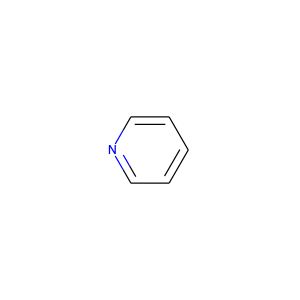

In [16]:
Draw.MolToImage(Chem.MolFromSmiles('C1=CC=NC=C1'))

In [22]:
GetBottcherComplexityFixSymmetry(Chem.MolFromSmiles('C1=CC=NC=C1'), True)

FULL ATOMS
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 3
C
	Symmetry Class: 1
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 3
C
	Symmetry Class: 2
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 3
N
	Symmetry Class: 3
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 5
		b_sub_i: 2
Current Complexity Score: 41.9674123853187


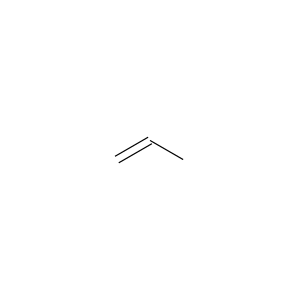

In [18]:
Draw.MolToImage(Chem.MolFromSmiles('C=CC'))

In [21]:
GetBottcherComplexityFixSymmetry(Chem.MolFromSmiles('C=CC'), True)

FULL ATOMS
C
	Symmetry Class: 1
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
C
	Symmetry Class: 2
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 3
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 1
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 1
Current Complexity Score: 12.169925001442312


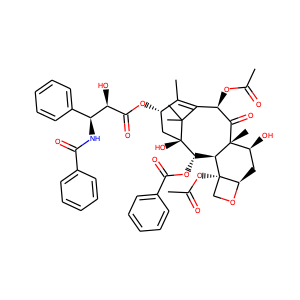

In [27]:
taxol = Chem.MolFromSmiles('CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C')
Draw.MolToImage(taxol)

In [30]:
GetBottcherComplexityFixSymmetry(taxol)

929.9373499826743

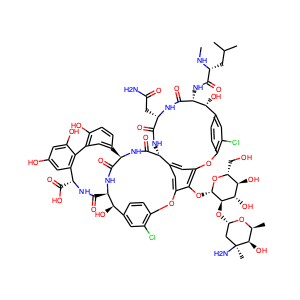

In [31]:
vancomycin = Chem.MolFromSmiles('C[C@H]1[C@H]([C@@](C[C@@H](O1)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2OC3=C4C=C5C=C3OC6=C(C=C(C=C6)[C@H]([C@H](C(=O)N[C@H](C(=O)N[C@H]5C(=O)N[C@@H]7C8=CC(=C(C=C8)O)C9=C(C=C(C=C9O)O)[C@H](NC(=O)[C@H]([C@@H](C1=CC(=C(O4)C=C1)Cl)O)NC7=O)C(=O)O)CC(=O)N)NC(=O)[C@@H](CC(C)C)NC)O)Cl)CO)O)O)(C)N)O')
Draw.MolToImage(vancomycin)

In [32]:
GetBottcherComplexityFixSymmetry(vancomycin)

1832.3401689352047

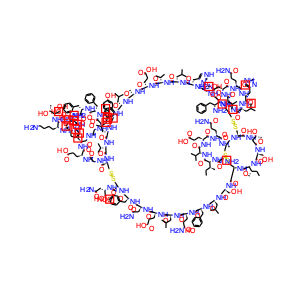

In [33]:
insulin = Chem.MolFromSmiles('CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[C@@H](CSSC[C@@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)CO)CC(C)C)CC3=CC=C(C=C3)O)CCC(=O)N)CC(C)C)CCC(=O)O)CC(=O)N)CC4=CC=C(C=C4)O)C(=O)N[C@@H](CC(=O)N)C(=O)O)C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CC5=CC=CC=C5)C(=O)N[C@@H](CC6=CC=CC=C6)C(=O)N[C@@H](CC7=CC=C(C=C7)O)C(=O)N[C@@H]([C@@H](C)O)C(=O)N8CCC[C@H]8C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]([C@@H](C)O)C(=O)O)C(C)C)CC(C)C)CC9=CC=C(C=C9)O)CC(C)C)C)CCC(=O)O)C(C)C)CC(C)C)CC2=CNC=N2)CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N1)CO)[C@@H](C)O)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)CN')
Draw.MolToImage(insulin)

In [34]:
GetBottcherComplexityFixSymmetry(insulin)

6555.0853808953325

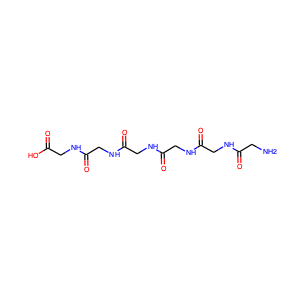

In [37]:
polyglycine = Chem.MolFromSmiles('NCC(NCC(NCC(NCC(NCC(NCC(O)=O)=O)=O)=O)=O)=O')
Draw.MolToImage(polyglycine)

In [38]:
GetBottcherComplexity(polyglycine)

387.27189309761826

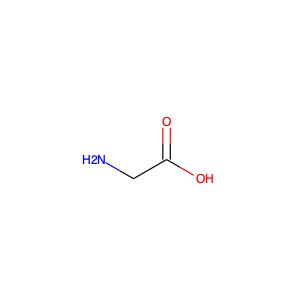

In [39]:
glycine = Chem.MolFromSmiles('NCC(O)=O')
Draw.MolToImage(glycine)

In [42]:
GetBottcherComplexity(glycine,True)

N
	Symmetry Class: 2
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 5
		b_sub_i: 1
C
	Symmetry Class: 0
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 2
C
	Symmetry Class: 1
	Current Parameter Values:
		d_sub_i: 2
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 4
		b_sub_i: 4
O
	Symmetry Class: 3
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 6
		b_sub_i: 1
O
	Symmetry Class: 4
	Current Parameter Values:
		d_sub_i: 1
		e_sub_i: 2
		s_sub_i: 1
		V_sub_i: 6
		b_sub_i: 2
Current Complexity Score: 44.98370619265935


In [41]:
print(str(GetBottcherComplexity(polyglycine)/GetBottcherComplexity(glycine)))

8.609159312907284


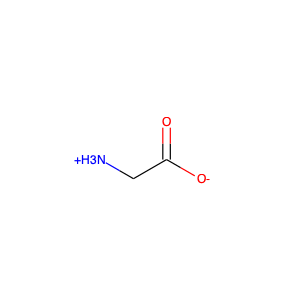

In [43]:
zwitterionic_glycine = Chem.MolFromSmiles('[NH3+]CC([O-])=O')
Draw.MolToImage(zwitterionic_glycine)

In [44]:
GetBottcherComplexityFixSymmetry(zwitterionic_glycine)

44.98370619265935